## Emotion recognition from speech using transfer learning

This notebook is based on the great fastai library developed and mantained by Jeremy Howard and Rachel Thomas
https://github.com/fastai/fastai

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys

print(sys.executable) #test environment

/home/asim/anaconda3/envs/tl-emotion/bin/python


In [8]:
from fastai import *
from fastai.vision import *
import numpy as np
import pandas as pd
import os.path
import librosa
import librosa.display
import IPython.display as ipd
from shutil import copyfile
import glob

print(os.getcwd()) #test cwd

/home/asim/Documents/emotion-from-speech


## Organizing audio data into folders according to class

* Each .csv file contain the .wav filenames associated with each emotion
* These .wav files are stored in 5 different folders, Session1, Session2 etc
* The next cell searches all the files associated with each emotion in those folders and stores them in specific folders organized by emotion
* The resulting audio files are stored in subflders inside the folder "audio"
* In tnis notebook we only consider the emotions "sadness", "anger", "happiness" and "neutral". Other classes could be include by modifying the code below

# IMPORTANT make sure to correct the path

In [9]:
#finish the recording videos soon!!!

pathData = os.getcwd() + '/testset-files'
wavData = pathData + '/wavTest2' #change this wavTest2 after running it on wavTest1
modelPath = os.getcwd() + '/models/'
pathImage = pathData + '/image2/' #change this to image2 to after creating image2 
! mkdir {pathImage}

emotions = ['ang','dis', 'fea', 'hap', 'neu', 'sad', 'sur']

# for emotion in emotions:
#     pathAudioEmotion = pathAudio + emotion
#     pathImageEmotion = pathImage + emotion
#     ! mkdir {pathAudioEmotion}
#     ! mkdir {pathImageEmotion}


mkdir: cannot create directory ‘/home/asim/Documents/emotion-from-speech/testset-files/image2/’: File exists


In [10]:
#ONLY RUN ONCE

# for filename in os.listdir(wavData):
#     if filename.endswith(".wav"): 
#         #print(os.path.join(wavData, filename))
#         #switch(filename[len(filename)-3:])
#         index_emotion = len(filename)-7
#         full_fname = os.path.join(wavData,filename)
#         #print(filename[index_emotion:index_emotion+3])
#         fname = filename[index_emotion:index_emotion+3]
#         if fname == 'ang':
#             copyfile(full_fname, os.path.join(pathAudio + 'ang', filename))
#         elif fname == 'dis':
#             copyfile(full_fname, os.path.join(pathAudio + 'dis', filename))
#         elif fname == 'fea':
#             copyfile(full_fname, os.path.join(pathAudio + 'fea', filename))
#         elif fname == 'hap':
#             copyfile(full_fname, os.path.join(pathAudio + 'hap', filename))
#         elif fname == 'neu':
#             copyfile(full_fname, os.path.join(pathAudio + 'neu', filename))
#         elif fname == 'sad':
#             copyfile(full_fname, os.path.join(pathAudio + 'sad', filename))
#         elif fname == 'sur':
#             copyfile(full_fname, os.path.join(pathAudio + 'sur', filename))
            
# for emotion in emotions:
#     print('Emotion: '+ emotion)
#     emotionFile = pd.read_csv(emotion[0:3]+'.csv')   
#     emotionFilenames = emotionFile['filenames']
#     for filename_target in emotionFilenames:
#         for filename in glob.iglob(wavData + '/**/' + filename_target + '.wav', recursive=True):
#             copyfile(filename, os.path.join(pathAudio + emotion, filename_target + '.wav'))

  
        

## Converting audio files into images based on spectrogram

The cells below create image files based on the signals in 'pathAudio' folder and store those images in 'pathImage' folder, orgazing the files in subfolders according to emotion class

I borrowed the functions in the cell below from https://dzlab.github.io/jekyll/update/2018/11/13/audio-classification/

In [11]:
def save_spectrogram(audio_fname, image_fname):
    y, sr = librosa.load(audio_fname, sr=None)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
    fig1 = plt.gcf()
    plt.axis('off')
    #plt.show() #dont draw these everytime anymore...
    #plt.draw()
    fig1.savefig(image_fname, dpi=100)

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def get_filename(path):
    absolute_fname = path.as_posix()
    absolute_fname_parts = absolute_fname.split('/')
    fname = absolute_fname_parts[len(absolute_fname_parts) - 1]
    return fname

def audio_to_spectrogram(audio_dir_path, image_dir_path=None):
    for paths in batch(audio_dir_path.ls(), 100): #change from 100
        for audio_path in paths:
            audio_filename = get_filename(audio_path)
            image_fname = audio_filename.split('.')[0] + '.png'
            if image_dir_path:
                image_fname = image_dir_path.as_posix() + '/' + image_fname
            if Path(image_fname).exists(): continue
            print(image_fname)
            #plot_spectrogram(image_fname)
            try:
                save_spectrogram(audio_path.as_posix(), image_fname)
            except ValueError as verr:
                print('Failed to process %s %s' % (image_fname, verr))
        # wait between every batch for xyz seconds


## Get the wavfiles into spectograms for testing... (should only run this once for both test sets)

In [12]:
for wavFile in wavData:
    pathAudioEmotion = Path(wavData+wavFile)
    pathImageEmotion = Path(pathImage+wavFile[:-4])
#     print(pathAudioEmotion)
#     print(pathImageEmotion)
    #audio_to_spectrogram(pathAudioEmotion, pathImageEmotion)
    
    #test below
    """
    ! {pathImageEmotion} #...continue only if hasn't been processed
    """
    
    if not os.path.isfile(pathImageEmotion):
        audio_to_spectrogram(pathAudioEmotion, pathImageEmotion)
        print(pathAudioEmotion)
        print(pathImageEmotion)

/home/asim/Documents/emotion-from-speech/testset-files/wavTest2
/home/asim/Documents/emotion-from-speech/testset-files/image2


FileNotFoundError: [Errno 2] No such file or directory: '/home/asim/Documents/emotion-from-speech/testset-files/wavTest2h'

## Training ResNet model using transfer learning 

In [21]:
np.random.seed(42)

'''
model stats: Test 1

num_workers=4
valid_pct=0.2
size=[400,600], tried 40/60, 200/300, 275/475, 300/450

model stats: Test 2

num_workers=4
valid_pct=0.2
size=[400,600], tried 40/60, 200/300, 275/475, 300/450
'''

# data = ImageDataBunch.from_folder(pathImage, train='.', valid_pct=0.2,
#         ds_tfms=None, size=[275,475], num_workers=4).normalize(imagenet_stats) 

test = ImageDataBunch.from_folder(pathImage, train='.', valid_pct=0.5,
        ds_tfms=None, size=[300,450], num_workers=4).normalize(imagenet_stats) 

model_name = 'stage-9v5-rn34'

learn = learn.load(Path(modelPath+model_name))

NameError: name 'learn' is not defined

In [8]:
test.classes

#learn.destroy() #if exists

['ang', 'dis', 'fea', 'hap', 'neu', 'sad', 'sur']

In [ ]:
test.show_batch(rows=3,figsize=(20,20))

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

NameError: name 'data' is not defined

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


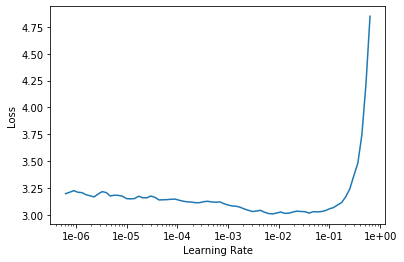

In [14]:
#torch.cuda.empty_cache() #if not empty

#learn.fit_one_cycle(1)

#learn.load('stage-9v5-rn34')

learn.lr_find()
learn.recorder.plot()


In [ ]:
#lr = 1e-2
lr = 1e-1
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.042626,2.608319,0.225205,04:58


In [13]:
learn.save('stage-17-rn34') #NOTE, ARCHICTECTURE MUST BE THE SAME & ORIGINAL AS INPUT!

In [ ]:
#learn.load('stage-9-rn34')

In [14]:
learn.unfreeze() #helps release the model, allows layers to be trained again...

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


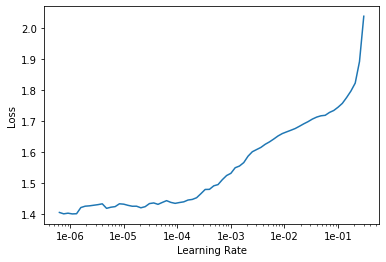

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
#best result comes on 3rd epoch

# learn.fit_one_cycle(10, slice(5e-7, lr/5)) #test improvement, also check size dimension change & analyze

learn.fit_one_cycle(5, slice(1e-6, lr/5)) #test improvement, also check size dimension change & analyze

epoch,train_loss,valid_loss,accuracy,time
0,1.485588,1.501414,0.427208,09:05
1,1.473597,1.490496,0.429720,09:05
2,1.298714,1.480580,0.439867,09:20
3,0.999766,1.547233,0.452627,09:20
4,0.719747,1.683913,0.447101,09:14


In [18]:
#learn.save('stage-2-rn34')
learn.save('stage-9v5-rn34') #300/450 or maybe 275/475

RuntimeError: cuda runtime error (4) : unspecified launch failure at /tmp/pip-req-build-58y_cjjl/torch/csrc/generic/serialization.cpp:23

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

In [30]:
interp.most_confused(min_val=2)

[('dis', 'neu', 472),
 ('hap', 'neu', 444),
 ('sad', 'neu', 412),
 ('fea', 'neu', 254),
 ('ang', 'neu', 240),
 ('neu', 'sad', 238),
 ('fea', 'sad', 233),
 ('dis', 'ang', 215),
 ('sur', 'neu', 198),
 ('ang', 'dis', 184),
 ('dis', 'sad', 163),
 ('neu', 'dis', 163),
 ('neu', 'sur', 149),
 ('neu', 'hap', 141),
 ('fea', 'sur', 136),
 ('dis', 'sur', 133),
 ('ang', 'sur', 117),
 ('sad', 'fea', 113),
 ('sur', 'ang', 111),
 ('hap', 'dis', 104),
 ('sad', 'dis', 96),
 ('sur', 'dis', 96),
 ('hap', 'sad', 95),
 ('dis', 'hap', 93),
 ('sur', 'fea', 85),
 ('fea', 'dis', 78),
 ('sad', 'ang', 75),
 ('hap', 'ang', 73),
 ('ang', 'sad', 72),
 ('hap', 'sur', 72),
 ('ang', 'hap', 67),
 ('dis', 'fea', 65),
 ('neu', 'ang', 63),
 ('fea', 'ang', 60),
 ('neu', 'fea', 59),
 ('sur', 'sad', 59),
 ('sad', 'hap', 58),
 ('sur', 'hap', 51),
 ('hap', 'fea', 50),
 ('fea', 'hap', 48),
 ('ang', 'fea', 42),
 ('sad', 'sur', 38)]

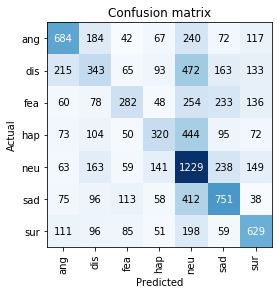

In [31]:
interp.plot_confusion_matrix()

In [16]:
print("Done!")

Done!


# Testing on dataset

In [34]:
#load model first
np.random.seed(42)
data = ImageDataBunch.from_folder(pathImage, train='.', valid_pct=0.2,
        ds_tfms=None, size=[300,450], num_workers=4).normalize(imagenet_stats) 
learn = cnn_learner(data, models.resnet34, metrics=accuracy) #initialize model architecture

model_name = 'stage-9-rn34'
learn = learn.load(Path(os.getcwd()+'/models/'+model_name))

test = ImageList.from_folder(os.getcwd() + '/testset-files' + '/image1')
data.add_test(test)
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
print(labels)
print(labels.size())

print(predictions)
print(predictions.size())


RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 1.8.weight: copying a param with shape torch.Size([7, 512]) from checkpoint, the shape in current model is torch.Size([1, 512]).
	size mismatch for 1.8.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1]).

# Make the following into CSV

In [ ]:
labels.size()

iterator = 0
files_dir = os.listdir(os.getcwd() + '/testset-files' + '/image')

results = {}
pred_results = {}

for result in labels:
    #print(emotions[result] + ' ' + files_dir[iterator][:-6]) #sort by the IDnumber on the right, then shorten num
    index = int(files_dir[iterator][:-6])
    ind2 = index
    results[ind2] = emotions[result] #to sort results by file (continue next cell)
    pred_results[ind2] = predictions[iterator] #to sort predictions by result
    iterator+=1

In [ ]:
#print(results)

#results.sort()
#print(sorted(results))

sortedResults = {}

for i in sorted(results):
    #print(results[i])
    sortedResults[i] = results[i]
    
print(sortedResults) #results csv is now sorted by file...

In [ ]:
for result in predictions:
    print(result)

In [ ]:
with open('results_test2.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for i in sortedResults:
        writer.writerow([i,sortedResults[i]])
    
with open('predictions_test2.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for i in sorted(pred_results):
        writer.writerow([list(pred_results[i])])